<a href="https://colab.research.google.com/github/ianblair87/573-orienteering/blob/main/573_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models
from torchvision import transforms
from torchvision.transforms import functional
from PIL import Image

In [ ]:
#with lines/circles
lines = "/content/drive/MyDrive/maps/карта 15.png"
# without lines/circles
nolines = "/content/drive/MyDrive/maps/карта 14.jpg"


In [ ]:
pic = cv2.imread(lines)
pic2 = cv2.imread(nolines)


In [ ]:
# def generate_mask(pic):
#     upper = np.array([255, 100, 255])
#     lower = np.array([160, 0, 170])

#     mask = cv2.inRange(pic, lower, upper)
#     mask = cv2.bitwise_and(pic, pic, mask = mask)

#     NEW_PINK = [255,100,255]
#     # making the layer a uniform pink
#     for i in np.arange(mask.shape[0]):
#       for j in np.arange(mask.shape[1]):
#         if not np.sum(mask[i][j]) == 0:
#           pic[i][j] = NEW_PINK

#     # getting a grayscale mask
#     white_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
#     return mask
#     # cv2_imshow(np.hstack([pic, pink_mask]))


In [11]:
def generate_lines_and_circles(PIC, LINE_COLOR, CIRCLE_RADIUS, NUM_CIRCLES, LINE_THICKNESS):

    # circle center coordinates
    coords = []

    lined_pic = np.copy(PIC)

    # NUM_CIRCLES circles, not overlapping
    for i in np.arange(NUM_CIRCLES):
      overlap = True

      while (overlap):
        is_good = True
        new_Coord = [random.randrange(int(PIC.shape[1] / 6), int(PIC.shape[1] * 5 / 6)), random.randrange(int(PIC.shape[0] / 6), int(PIC.shape[0] * 5 / 6))]
        for other_Coord in coords:
          if math.dist(new_Coord, other_Coord) < 110:
            is_good = False
        if is_good:
          overlap = False
      coords.append(new_Coord)
      cv2.circle(lined_pic, new_Coord, CIRCLE_RADIUS, LINE_COLOR, LINE_THICKNESS)

    # lines connecting circles
    for i in np.arange(NUM_CIRCLES - 1):
      adj = coords[i][1] - coords[i+1][1]
      opp = coords[i][0] - coords[i+1][0]
      hyp = math.sqrt(adj * adj + opp * opp)
      sin = opp/hyp
      cos = adj/hyp
      center1 = [int(coords[i][0] -  sin*CIRCLE_RADIUS), int(coords[i][1] - cos*CIRCLE_RADIUS)]
      center2 = [int(coords[i+1][0] +  sin*CIRCLE_RADIUS), int(coords[1+i][1] + cos*CIRCLE_RADIUS)]
      line_coord = [center1, center2]
      cv2.line(lined_pic, line_coord[0], line_coord[1], LINE_COLOR, LINE_THICKNESS)

    return lined_pic, coords

def generate_figures(PIC, LINE_COLOR, CIRCLE_RADIUS, COORDS, LINE_THICKNESS):
  figured_pic = np.copy(PIC)
  for i in range(len(COORDS)):
    # LABELS for circles
    cv2.putText(figured_pic, str(i), COORDS[i], cv2.FONT_HERSHEY_DUPLEX, 1.2, LINE_COLOR, LINE_THICKNESS, cv2.LINE_AA)

  return figured_pic

def generate_mask(pic, color):
  upper = np.array([color[0] + 1, color[1] + 1, color[2] + 1])
  lower = np.array([color[0] - 1, color[1] - 1, color[2] - 1])

  mask = cv2.inRange(pic, lower, upper)
  pink_mask = cv2.bitwise_and(pic, pic, mask = mask)
  return pink_mask





In [4]:
# Training data should me maps with existing labels
path = "/content/drive/MyDrive/maps/"
data_with_labels = [path+element for element in ["карта 15.png", "карта 13.jpg", "карта 10.png", "карта 9.png", "карта 8.png", "карта 7.png", "карта 6.png",  "карта 5.png"]]
training_data = [path+element for element in ["карта 14.jpg", "карта 12.jpg", "Kartta 106 - 2017.jpg", "Kartta 12 - 2018.jpg"]]
print(training_data)
validation_data = [path+"карта 11.jpg"]

['/content/drive/MyDrive/maps/карта 14.jpg', '/content/drive/MyDrive/maps/карта 12.jpg', '/content/drive/MyDrive/maps/Kartta 106 - 2017.jpg', '/content/drive/MyDrive/maps/Kartta 12 - 2018.jpg']


In [13]:
# colors = []
training = np.zeros([20, 800, 800, 3])
training_masks = np.zeros([20, 800, 800])
training_target = np.zeros([20, 800, 800, 3])
validation = np.zeros([4, 600, 600, 3])
validation_masks = np.zeros([4, 600, 600])
validation_target = np.zeros([4, 600, 600, 3])


def get_random_crop(image, crop_height, crop_width):

    max_x = image.shape[1] - crop_width
    max_y = image.shape[0] - crop_height
    # print([max_x, max_y])

    x = np.random.randint(0, max_x)
    y = np.random.randint(0, max_y)

    crop = image[y: y + crop_height, x: x + crop_width]

    return crop


for i in range(5):
  j = 0
  for data in training_data:
    pic = cv2.imread(data)

    pic = get_random_crop(pic, 800, 800)

    training_target[i*4 + j] = pic

    b, g, r, circle_radius, num_circles, line_thickness = random.randrange(0, 255), random.randrange(0, 100), random.randrange(160, 255), random.randrange(25, 50), random.randrange(5, 15), random.randrange(5, 10)
    color = [b, g, r]
    lined_pic, coords = generate_lines_and_circles(pic, color, circle_radius, num_circles, line_thickness)

    figured_pic = generate_figures(lined_pic, color, circle_radius, coords, line_thickness)
    training[i*4 + j] = figured_pic

    mask = generate_mask(figured_pic, color)
    # BW mask
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask[mask != 0] = 1
    training_masks[i*4 + j] = mask

    j+=1
  # numpy_horizontal_concat = np.concatenate((training_target[i], training[i]), axis=1)
  # cv2_imshow(numpy_horizontal_concat)
  # cv2_imshow(training_masks[i]*255)
i = 0
for data in validation_data:
  pic = cv2.imread(data)

  pic = get_random_crop(pic, 600, 600)
  validation_target[i] = pic

  b, g, r, circle_radius, num_circles, line_thickness = random.randrange(0, 255), random.randrange(0, 100), random.randrange(160, 255), random.randrange(40, 65), random.randrange(5, 15), random.randrange(5, 10)
  color = [b, g, r]
  lined_pic, coords = generate_lines_and_circles(pic, color, circle_radius, num_circles, line_thickness)



  figured_pic = generate_figures(lined_pic, color, circle_radius, coords, line_thickness)
  validation[i] = figured_pic

  mask = generate_mask(figured_pic, color)
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  mask[mask != 0] = 1
  validation_masks[i] = mask



  i+=1




In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 1, kernel_size=5, padding=2),
            nn.Sigmoid()
        )

        def weights_init(m):
          if isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)

        self.features.apply(weights_init)
        torch.nn.utils.clip_grad_norm_(self.features.parameters(), max_norm=1)



    def forward(self, x):
        return self.features(x)

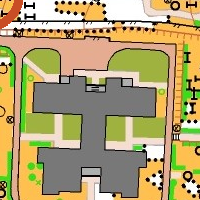

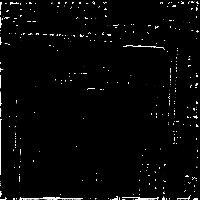

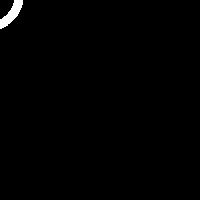

Epoch 1/1000, Val Loss: 0.9632635712623596
Epoch 11/1000, Val Loss: 1.0023434162139893


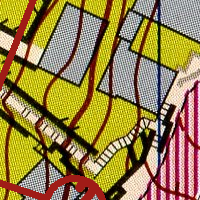

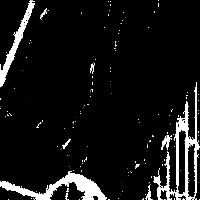

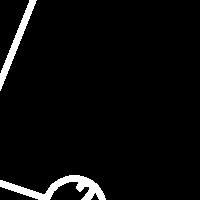

Epoch 21/1000, Val Loss: 0.9228203296661377
Epoch 31/1000, Val Loss: 0.7732215523719788


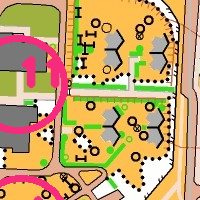

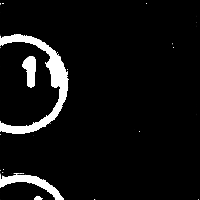

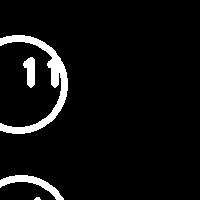

Epoch 41/1000, Val Loss: 0.7300121784210205
Epoch 51/1000, Val Loss: 0.655346155166626


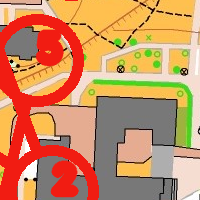

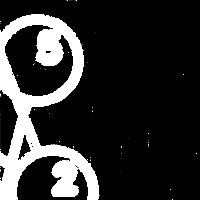

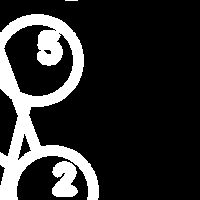

Epoch 61/1000, Val Loss: 0.6312505602836609
Epoch 71/1000, Val Loss: 0.6205887794494629


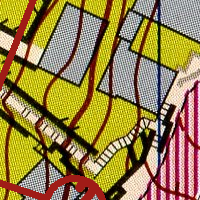

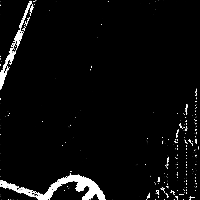

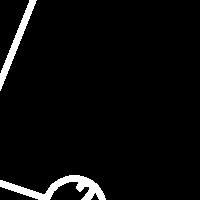

Epoch 81/1000, Val Loss: 0.6325913667678833
Epoch 91/1000, Val Loss: 0.6377508640289307


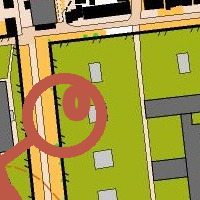

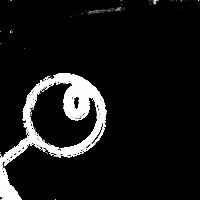

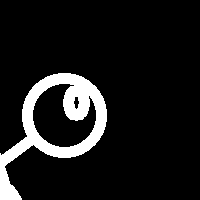

Epoch 101/1000, Val Loss: 0.6303865313529968
Epoch 111/1000, Val Loss: 0.6295349597930908


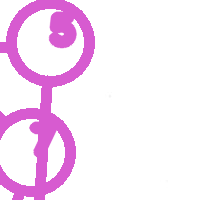

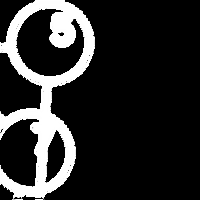

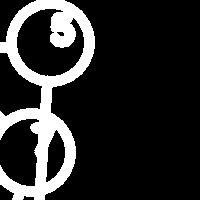

Epoch 121/1000, Val Loss: 0.6217483282089233
Epoch 131/1000, Val Loss: 0.623241126537323


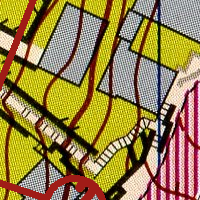

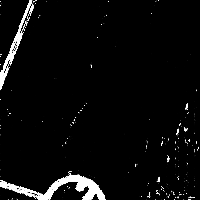

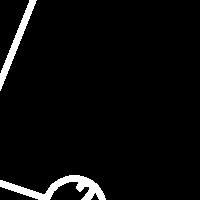

Epoch 141/1000, Val Loss: 0.6195766925811768
Epoch 151/1000, Val Loss: 0.6175562739372253


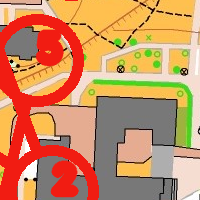

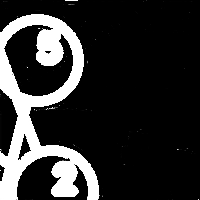

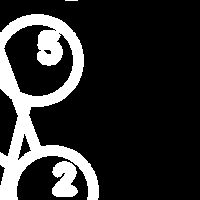

Epoch 161/1000, Val Loss: 0.614922285079956
Epoch 171/1000, Val Loss: 0.6075530052185059


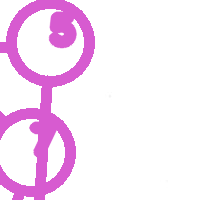

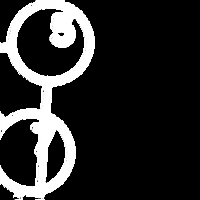

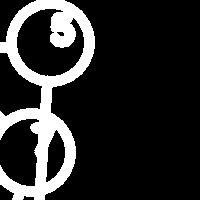

Epoch 181/1000, Val Loss: 0.612884521484375
Epoch 191/1000, Val Loss: 0.6136593222618103


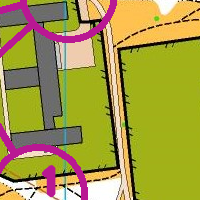

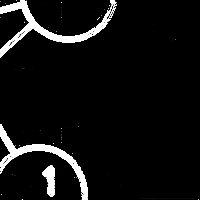

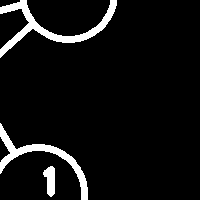

Epoch 201/1000, Val Loss: 0.6118125915527344
Epoch 211/1000, Val Loss: 0.6145350337028503


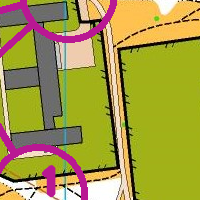

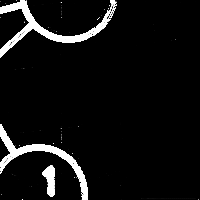

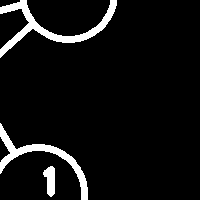

Epoch 221/1000, Val Loss: 0.5998788475990295
Epoch 231/1000, Val Loss: 0.5996267795562744


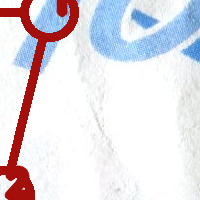

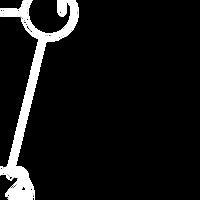

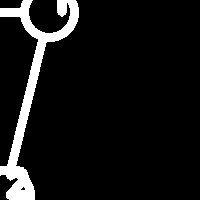

Epoch 241/1000, Val Loss: 0.5856262445449829
Epoch 251/1000, Val Loss: 0.5768303871154785


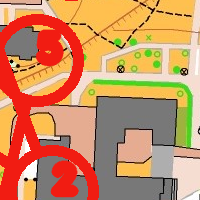

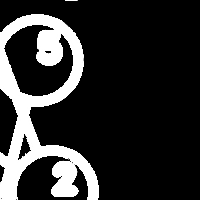

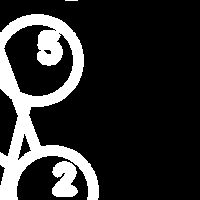

Epoch 261/1000, Val Loss: 0.8152506351470947
Epoch 271/1000, Val Loss: 0.5420863628387451


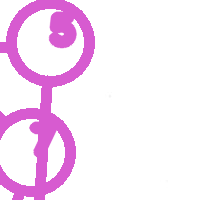

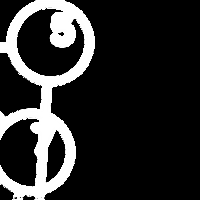

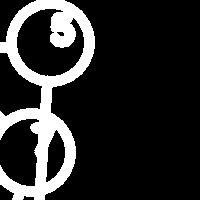

Epoch 281/1000, Val Loss: 0.5848873853683472
Epoch 291/1000, Val Loss: 0.5723646879196167


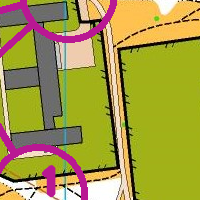

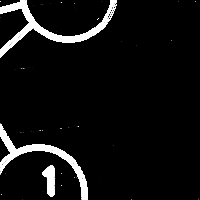

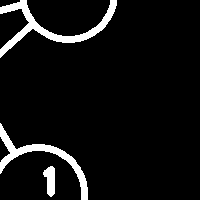

Epoch 301/1000, Val Loss: 0.5739231705665588
Epoch 311/1000, Val Loss: 0.5702129602432251


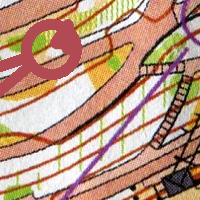

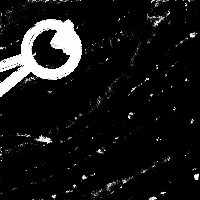

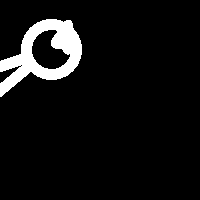

Epoch 321/1000, Val Loss: 0.5685432553291321
Epoch 331/1000, Val Loss: 0.5642509460449219


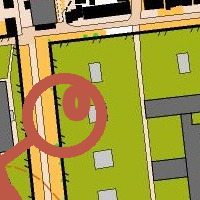

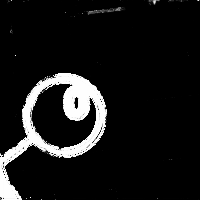

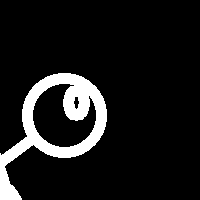

Epoch 341/1000, Val Loss: 0.5654217004776001
Epoch 351/1000, Val Loss: 0.5649974942207336


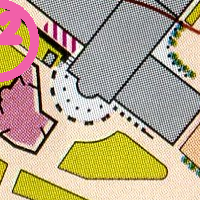

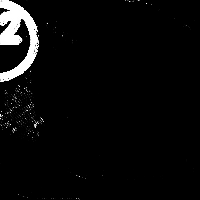

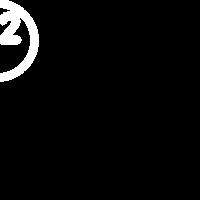

Epoch 361/1000, Val Loss: 0.5614074468612671
Epoch 371/1000, Val Loss: 0.5599843859672546


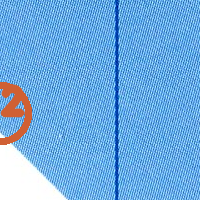

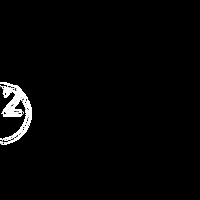

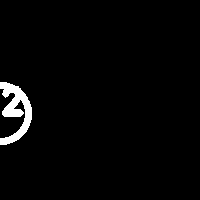

Epoch 381/1000, Val Loss: 0.5564450025558472
Epoch 391/1000, Val Loss: 0.5573925971984863


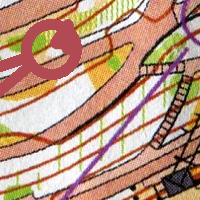

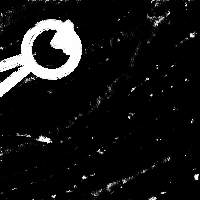

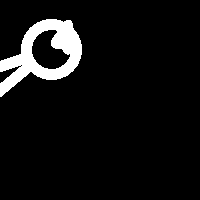

Epoch 401/1000, Val Loss: 0.5568799376487732
Epoch 411/1000, Val Loss: 0.5563135147094727


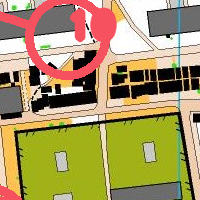

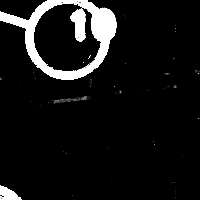

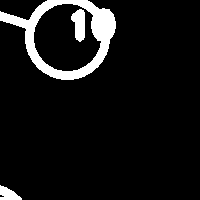

Epoch 421/1000, Val Loss: 0.557854413986206
Epoch 431/1000, Val Loss: 0.5579217672348022


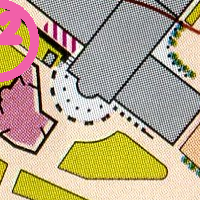

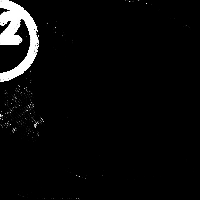

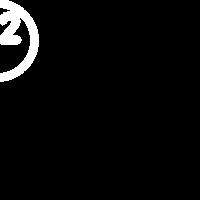

Epoch 441/1000, Val Loss: 0.5575668215751648
Epoch 451/1000, Val Loss: 0.5575709939002991


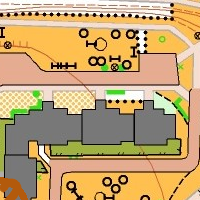

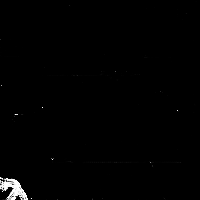

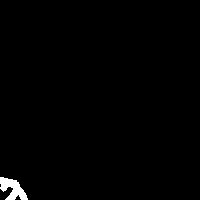

Epoch 461/1000, Val Loss: 0.5577672123908997
Epoch 471/1000, Val Loss: 0.5583205819129944


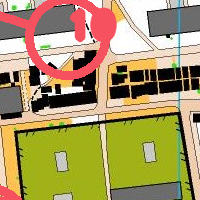

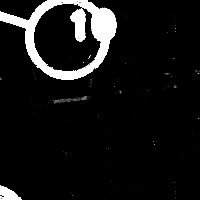

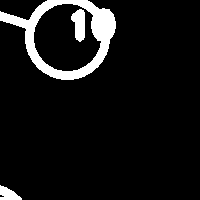

Epoch 481/1000, Val Loss: 0.5577493906021118
Epoch 491/1000, Val Loss: 0.5573272705078125


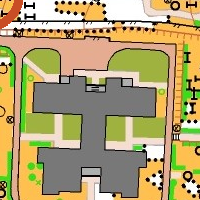

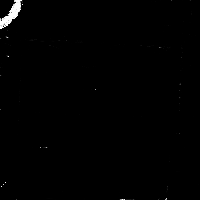

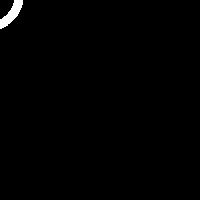

Epoch 501/1000, Val Loss: 0.5585514903068542
Epoch 511/1000, Val Loss: 0.5577239990234375


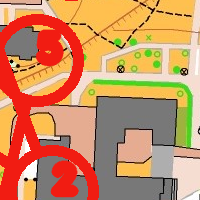

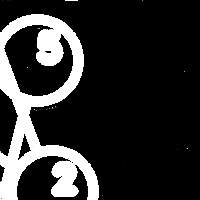

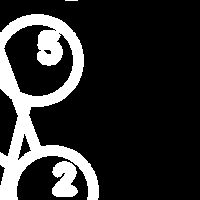

Epoch 521/1000, Val Loss: 0.5588752031326294
Epoch 531/1000, Val Loss: 0.5584841966629028


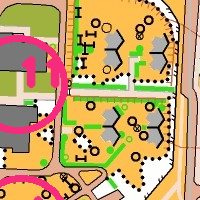

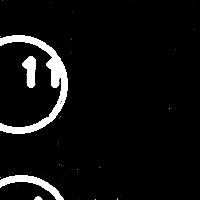

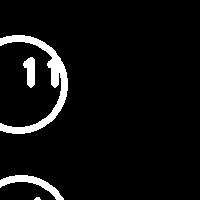

Epoch 541/1000, Val Loss: 0.5563101172447205
Epoch 551/1000, Val Loss: 0.5571012496948242


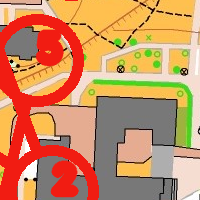

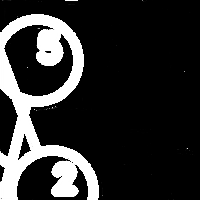

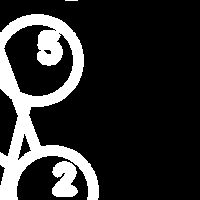

Epoch 561/1000, Val Loss: 0.557246744632721
Epoch 571/1000, Val Loss: 0.556178092956543


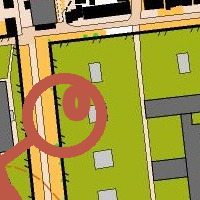

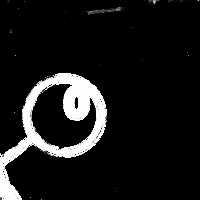

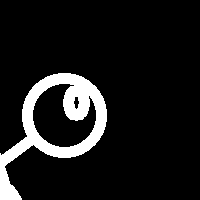

Epoch 581/1000, Val Loss: 0.5561403632164001
Epoch 591/1000, Val Loss: 0.556786060333252


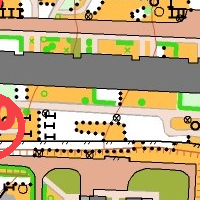

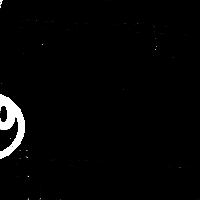

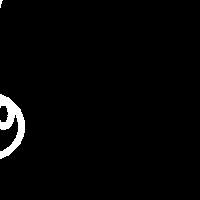

Epoch 601/1000, Val Loss: 0.5559893846511841
Epoch 611/1000, Val Loss: 0.5551276803016663


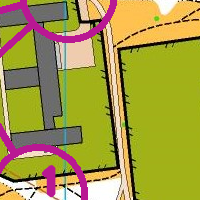

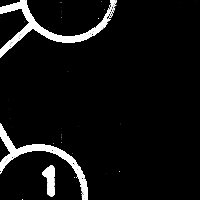

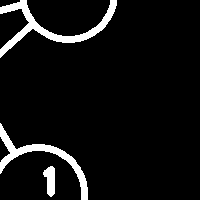

Epoch 621/1000, Val Loss: 0.5570175051689148
Epoch 631/1000, Val Loss: 0.5566006898880005


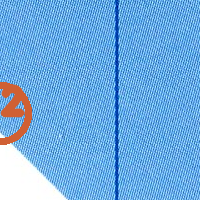

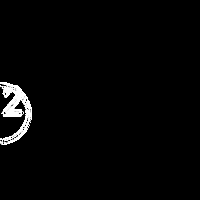

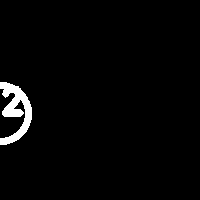

Epoch 641/1000, Val Loss: 0.5540865063667297
Epoch 651/1000, Val Loss: 0.5534886717796326


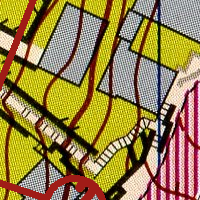

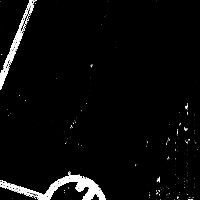

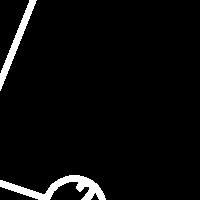

Epoch 661/1000, Val Loss: 0.5560628175735474
Epoch 671/1000, Val Loss: 0.5550196170806885


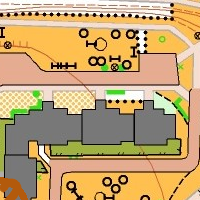

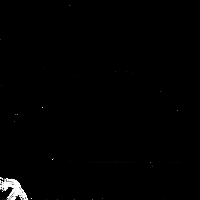

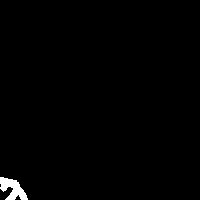

Epoch 681/1000, Val Loss: 0.5547587871551514
Epoch 691/1000, Val Loss: 0.5559841990470886


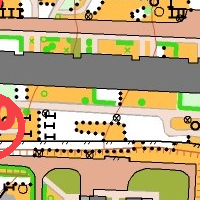

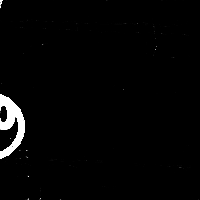

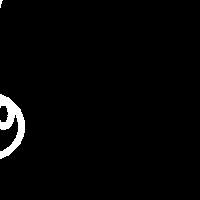

Epoch 701/1000, Val Loss: 0.5557857751846313
Epoch 711/1000, Val Loss: 0.5547512769699097


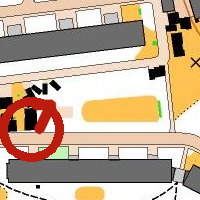

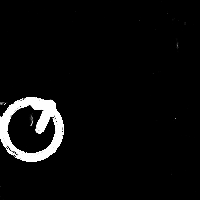

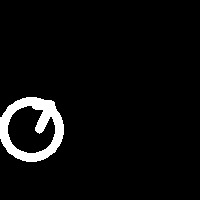

Epoch 721/1000, Val Loss: 0.5542981624603271
Epoch 731/1000, Val Loss: 0.5556331276893616


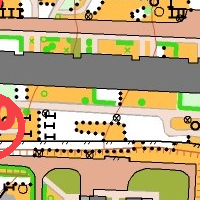

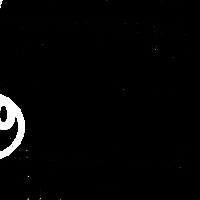

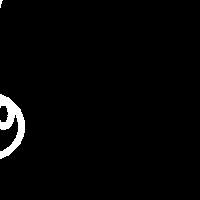

Epoch 741/1000, Val Loss: 0.5523458123207092
Epoch 751/1000, Val Loss: 0.5523873567581177


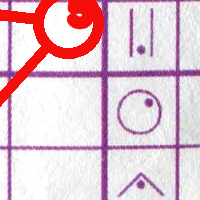

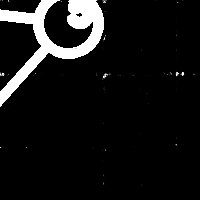

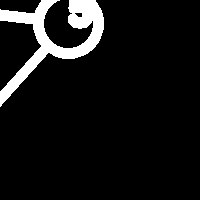

Epoch 761/1000, Val Loss: 0.5532782077789307
Epoch 771/1000, Val Loss: 0.5523884892463684


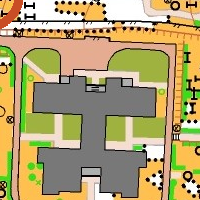

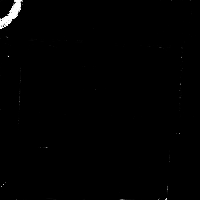

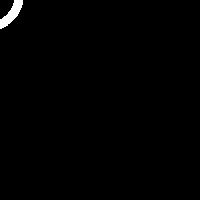

Epoch 781/1000, Val Loss: 0.5515270233154297
Epoch 791/1000, Val Loss: 0.5505825877189636


In [ ]:
bw_t_masks_tensor = torch.tensor(training_masks).unsqueeze(1).to(torch.float32)
bw_v_masks_tensor = torch.tensor(validation_masks).unsqueeze(1).to(torch.float32)

training_tensor = torch.tensor(training).permute(0,3,1,2).to(torch.float32)
validation_tensor = torch.tensor(validation).permute(0,3,1,2).to(torch.float32)

crop_params = transforms.RandomCrop.get_params(training_tensor, (200, 200))
resized_images = functional.crop(training_tensor, *crop_params)
resized_masks = functional.crop(bw_t_masks_tensor, *crop_params)

crop_params = transforms.RandomCrop.get_params(validation_tensor, (200, 200))
resized_val_images = functional.crop(validation_tensor, *crop_params)
resized_val_masks = functional.crop(bw_v_masks_tensor, *crop_params)

# Define your custom dataset class and transformations
training_with_labels = combined_data = list(zip(resized_images, resized_masks))
validation_with_labels = combined_data = list(zip(resized_val_images, resized_val_masks))

# Create data loaders

train_loader = DataLoader(training_with_labels, batch_size=20, shuffle=True)
val_loader = DataLoader(validation_with_labels, batch_size=5)

# Define the model
model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    for images, masks in train_loader:


        optimizer.zero_grad()
        outputs = model(images)

        if (epoch % 20 == 0):
          cv2_imshow(images[0].permute(1, 2, 0).detach().numpy())

          X = outputs[0].permute(1, 2, 0).detach().numpy()
          cv2_imshow(X * 255)

          Y = masks[0].permute(1, 2, 0).detach().numpy()
          cv2_imshow(Y * 255)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        for images, masks in val_loader:
            outputs = model(images)
            val_loss = criterion(outputs, masks)
            total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        if (epoch % 10 == 0):
          print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {avg_val_loss}')

# Save the trained model
torch.save(model.state_dict(), 'layer_separation_model.pth')

In [36]:
testers = [cv2.imread(path+element) for element in ["карта 15.png", "карта 13.jpg", "карта 10.png", "карта 9.png", "карта 8.png", "карта 7.png", "карта 6.png",  "карта 5.png"]]


1.0


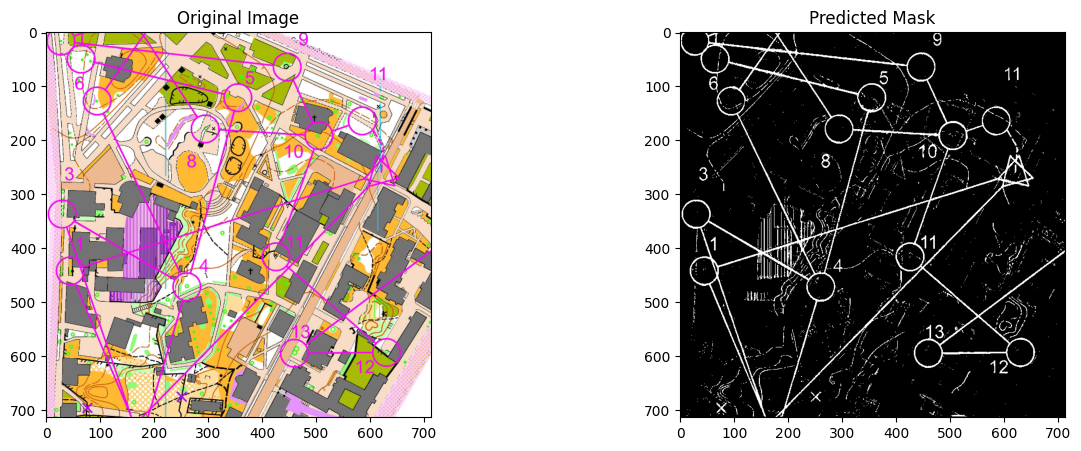

1.0


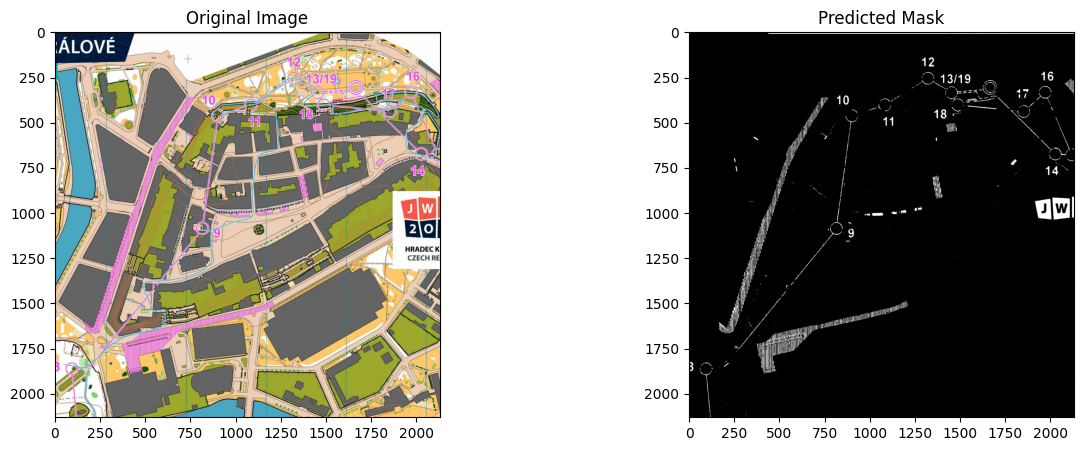

1.0


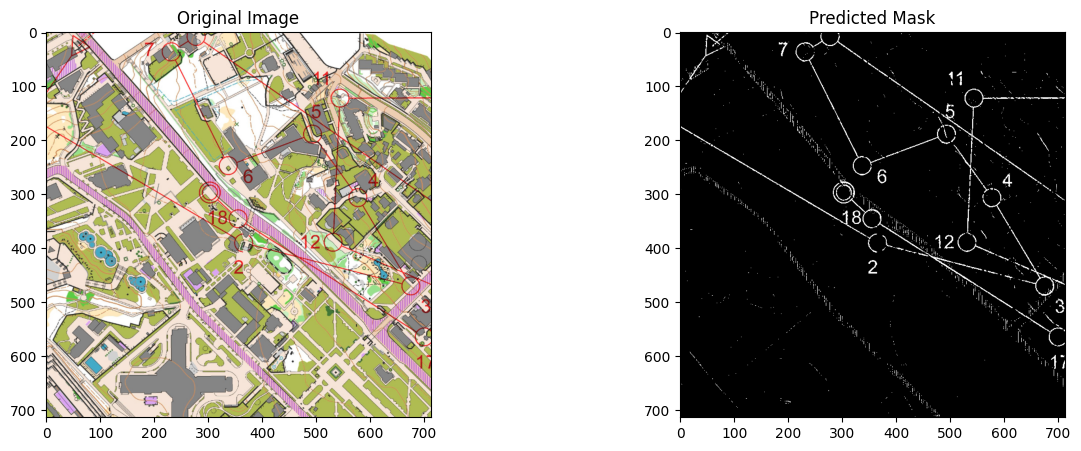

1.0


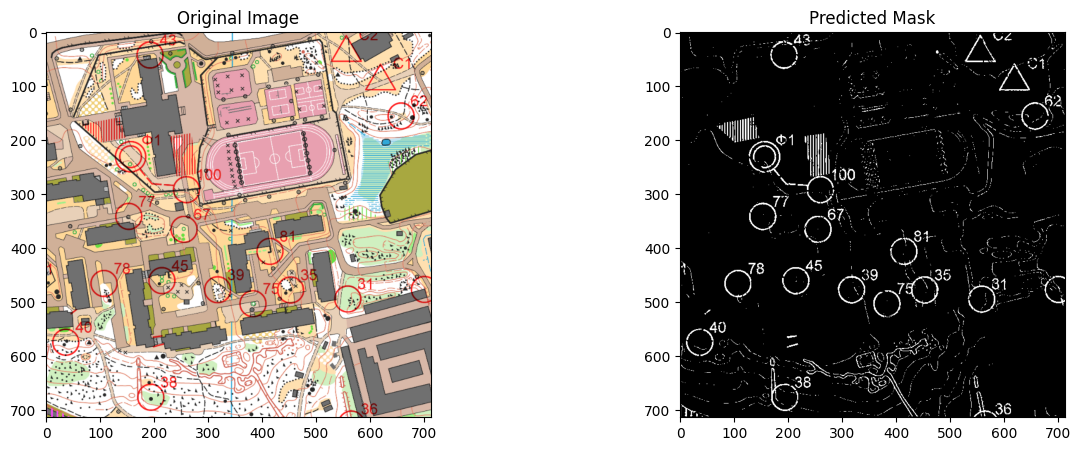

1.0


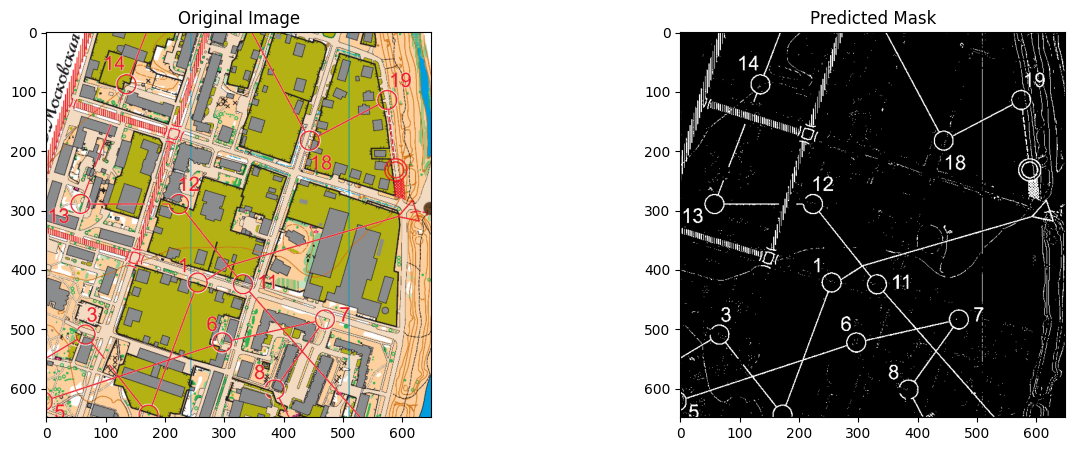

1.0


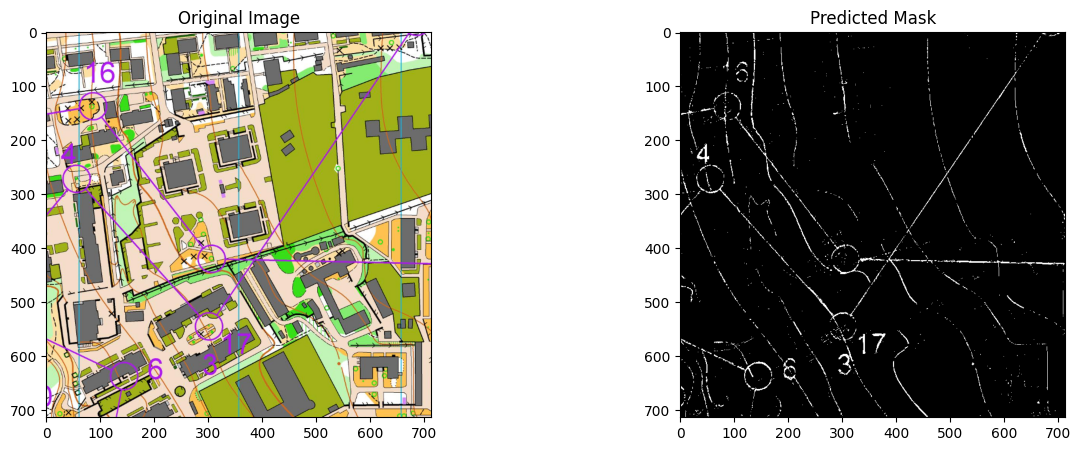

1.0


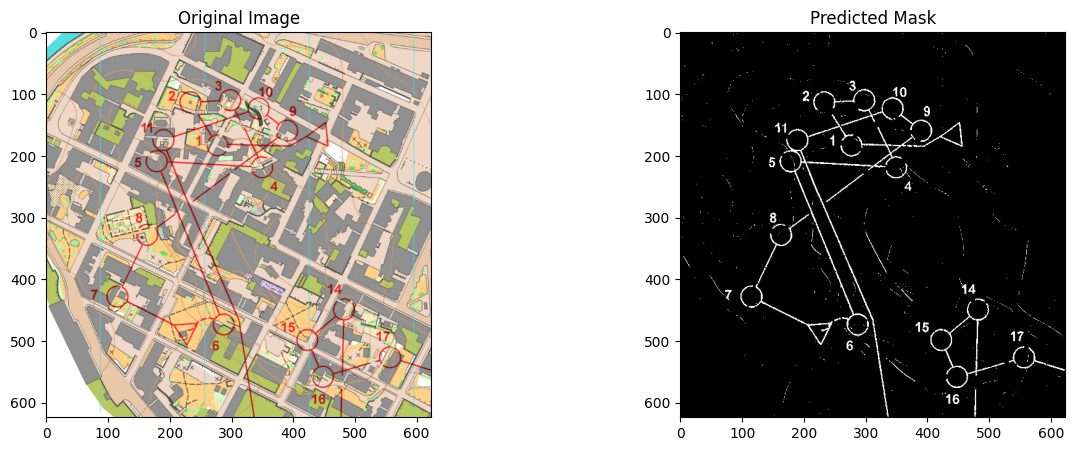

1.0


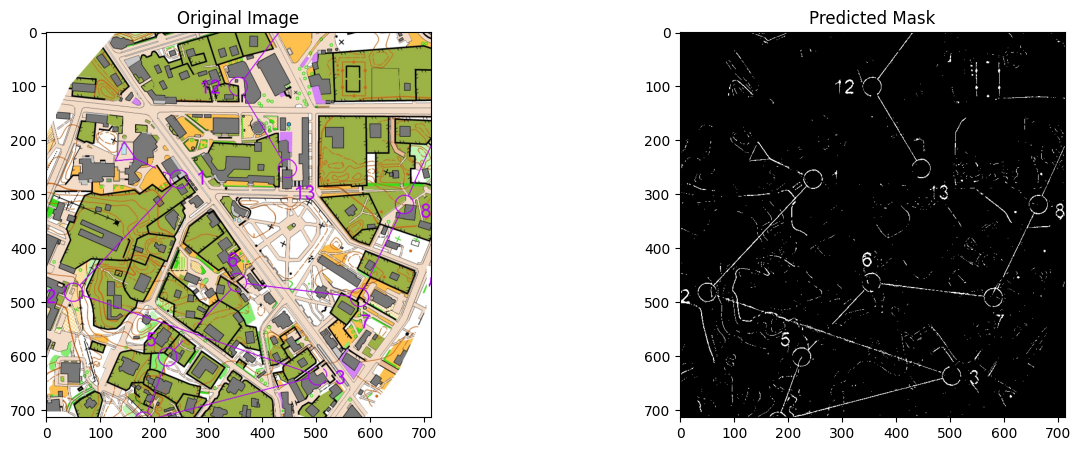

In [16]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 1, kernel_size=5, padding=2),
            nn.Sigmoid()
        )

        def weights_init(m):
          if isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)

        self.features.apply(weights_init)
        torch.nn.utils.clip_grad_norm_(self.features.parameters(), max_norm=1)



    def forward(self, x):
        return self.features(x)


# Evaluate the model on test data
model = SimpleCNN()
model.load_state_dict(torch.load('layer_separation_model.pth'))
model.eval()
predictions_list = []
with torch.no_grad():
    for i in range(8):
      testing_tensor = torch.tensor(testers[i]).permute(2, 0, 1).to(torch.float32)
      test_loader = DataLoader(testing_tensor, batch_size=8, shuffle=False)
      for image in test_loader:
          image = image.unsqueeze(0)

          outputs = model(image)

          predictions = (outputs > 0.5).float()

          fig, axs = plt.subplots(1, 2, figsize=(15, 5))

          axs[0].imshow(cv2.cvtColor(testers[i], cv2.COLOR_BGR2RGB))
          axs[0].set_title("Original Image")

          prediction = np.array(predictions[0].squeeze())
          print(np.max(prediction))
          predictions_list.append(prediction)
          axs[1].imshow(prediction, cmap="gray")
          axs[1].set_title("Predicted Mask")

          plt.show()
